## **Image Classification Model Deployment Oleh Nurul Tazkiyah Adam**

In [1]:
# memastikan tensorflow yang digunakan versi 2 atau lebih
import tensorflow as tf
print(tf.__version__)

2.9.2


In [2]:
! pip install -q kaggle

In [3]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nurultazkiyah","key":"59098faed20e7cf6c0c18addafd2231c"}'}

In [4]:
!chmod 600 /content/kaggle.json

In [6]:
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

100% 673M/675M [00:31<00:00, 23.9MB/s]
100% 675M/675M [00:31<00:00, 22.2MB/s]


In [12]:
import os, zipfile
local_zip = '/content/cell-images-for-detecting-malaria.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content') #unzip atau mengekstrak file zip dataset
zip_ref.close()

In [13]:
os.remove("/content/cell_images/Parasitized/Thumbs.db")
os.remove("/content/cell_images/Uninfected/Thumbs.db")
os.remove("/content/cell_images/cell_images/Parasitized/Thumbs.db")
os.remove("/content/cell_images/cell_images/Uninfected/Thumbs.db")

In [14]:
base_dir = '/content/cell_images'

In [15]:
import PIL

#untuk mengetahui ukuran size gambar pada dataset berbeda-beda 

def read_files(startpath):
  image_files = []
  for dirname, dirnames, filenames in os.walk(startpath):
    for filename in filenames:
      image_files.append(os.path.join(dirname, filename))
  
  return image_files

full_dirs = read_files(base_dir)
image_sizes = []
for file in full_dirs:
  image = PIL.Image.open(file)
  width, height = image.size
  image_sizes.append(f'{width}x{height}')

unique_sizes = set(image_sizes)

print(f'Size all images: {len(image_sizes)}')
print(f'Size unique images: {len(unique_sizes)}')
print(f'First 10 unique images: \n{list(unique_sizes)[:10]}')

Size all images: 55116
Size unique images: 1627
First 10 unique images: 
['181x187', '175x178', '85x130', '196x145', '103x139', '136x178', '103x142', '106x100', '226x220', '70x46']


In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IDG = ImageDataGenerator(
  rescale=1./255, # membagi ke ukuran pixel terkecil kemudian augmentasi
  validation_split=0.2, # membagi ke ukuran pixel terkecil kemudian augmentasi
  zoom_range=0.2,
  shear_range=0.2,
  rotation_range=0.2
)

In [18]:
training_generator = IDG.flow_from_directory(
  base_dir,
  subset='training',
  target_size=(150,150),
  seed=42,
  batch_size=64,
  interpolation='nearest',
  class_mode='binary',
  classes= ['Parasitized','Uninfected']
)

validation_generator = IDG.flow_from_directory(
  base_dir,
  subset='validation',
  target_size=(150,150),
  seed=42,
  batch_size=64,
  interpolation='nearest',
  class_mode='binary',
  classes= ['Parasitized','Uninfected']
)

Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


In [19]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input

base_model = tf.keras.applications.MobileNetV2(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False
)

9406464/9406464 [==============================] - 0s 0us/step


In [20]:
base_model.trainable = True

In [25]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 36, 36, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)      

In [26]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.0001),
              metrics=['accuracy'])

In [27]:
class berhenti(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if((logs.get('accuracy') > 0.92) and (logs.get('val_accuracy') > 0.92)):
      print('\nalhamdulillah akurasi mencapai 92%')
      self.model.stop_training = True
iniCallback = berhenti()

In [28]:
history = model.fit(training_generator,
                    epochs=100,                  
                    validation_data = validation_generator,
                    verbose=1,
                    callbacks=[iniCallback])

Epoch 1/100
345/345 [==============================] - 184s 501ms/step - loss: 0.6347 - accuracy: 0.6358 - val_loss: 0.4980 - val_accuracy: 0.8093
Epoch 2/100
345/345 [==============================] - 175s 508ms/step - loss: 0.3122 - accuracy: 0.8719 - val_loss: 0.2180 - val_accuracy: 0.9334
Epoch 3/100
345/345 [==============================] - 175s 506ms/step - loss: 0.2117 - accuracy: 0.9347 - val_loss: 0.2389 - val_accuracy: 0.9185
Epoch 4/100
345/345 [==============================] - ETA: 0s - loss: 0.1951 - accuracy: 0.9408
alhamdulillah akurasi mencapai 92%
345/345 [==============================] - 174s 505ms/step - loss: 0.1951 - accuracy: 0.9408 - val_loss: 0.2061 - val_accuracy: 0.9372


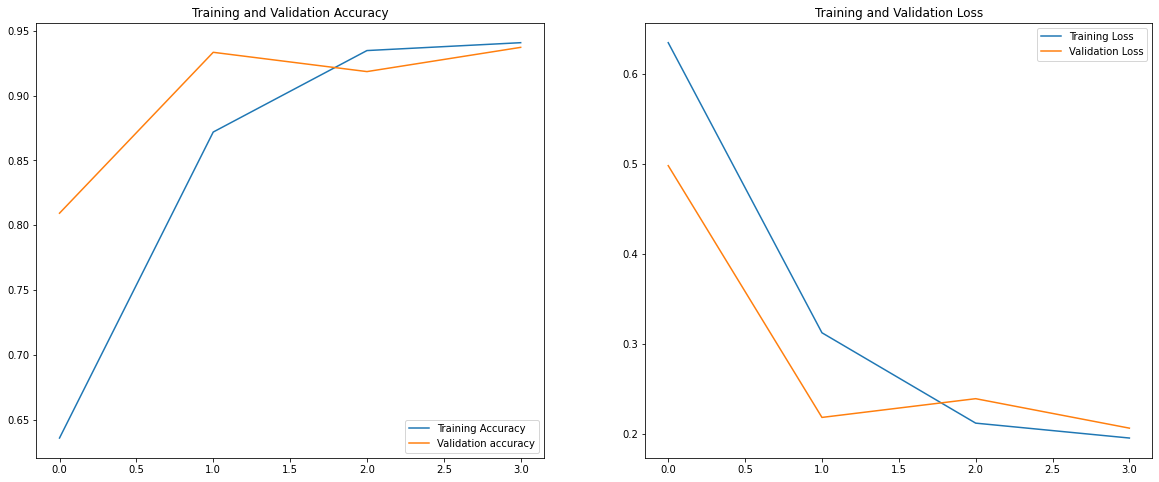

In [29]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [30]:
import warnings

warnings.filterwarnings('ignore') # Menghilangkan Warning

# Convert model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [31]:
from google.colab import files

# Download the flower model
files.download('/content/model.tflite')

print('`model.tflite` has been downloaded')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

`model.tflite` has been downloaded


## Referensi


1.   [dwinuragustina-ImageClassificationModelDeployment](https://github.com/dwinuragustina/ImageClassificationModelDeployment/blob/main/Image%20Classification%20Model%20Deployment.ipynb)
2.   [AzharRizky-Image-Classification-Model-Deployment](https://github.com/AzharRizky/Image-Classification-Model-Deployment/blob/main/Submission%20Akhir%20-%20Image%20Classification%20Model%20Deployment.ipynb)
3.   [ridwanabdiansah29-Submission-Dicoding-Image-Classification-Model-Deployment](https://github.com/ridwanabdiansah29/Submission-Dicoding-Image-Classification-Model-Deployment/blob/main/RIDWAN_ABDIANSAH_M193X0386_M06_IMAGECLASSIFICATIONDEPLOYMENT.ipynb)
4.   [hazmicokro-Image-Classification-Rock-Paper-Scissors-with-Model-Deployment](https://github.com/hazmicokro/Image-Classification-Rock-Paper-Scissors-with-Model-Deployment/blob/main/Submission_Akhir_RPS_BPML_Hazmi_Cokro.ipynb)
5.   [diniramdhni-Image-Classification-Model-Deployment](https://github.com/diniramdhni/Image-Classification-Model-Deployment/blob/main/Copy_of_Proyek_Dicoding_Image_Classification_Model_Deployment_.ipynb)


